In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import tensorflow as tf

2023-04-16 10:14:45.620150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_lsq_results(result_dir: str,
                           num_runs: int,
                           failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_ts_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [5]:
def process_original_albo_lsq_results(result_dir: str,
                                      num_runs: int,
                                      failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [6]:
def process_original_albo_gsbp_results(result_dir: str,
                                       num_runs: int,
                                       failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

### LSQ

In [7]:
ts_al_kkt_lsq_results, ts_al_kkt_lsq_results_mean, ts_al_kkt_lsq_results_median, ts_al_kkt_lsq_results_std = process_ts_lsq_results("../results/04-04-23/lsq/al_kkt_update/data/", 100, 1.3)
ts_al_original_lsq_results, ts_al_original_lsq_results_mean, ts_al_original_lsq_results_median, ts_al_original_lsq_results_std = process_ts_lsq_results("../results/04-04-23/lsq/al_original_update/data/", 100, 1.3)
original_albo_lsq_results, original_albo_lsq_results_mean, original_albo_lsq_results_median, original_albo_lsq_results_std = process_original_albo_lsq_results("../results/original_albo/lsq/slack_al_optim_correct_rho_update_urate_one/data/", 100, 1.3)
random_lsq_results, random_lsq_results_mean, random_lsq_results_median, random_lsq_results_std = process_ts_lsq_results("../results/11-04-23/lsq_random/", 100, 1.3)
consistent_results, consistent_results_mean, consistent_results_median, consistent_results_std = process_ts_lsq_results("../results/14-04-23/lsq_fully_consistent/data/", 100, 1.3)

2023-04-16 10:14:53.539440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
print(original_albo_lsq_results_median[30])

0.6081356696655644


In [9]:
print(ts_al_kkt_lsq_results[:,-1])

[0.5998074  0.5997952  0.59979959 0.59980021 0.5998013  0.59979418
 0.59981133 0.5998072  0.59979287 0.599803   0.59980477 0.59979392
 0.59979727 0.59979697 0.59980195 0.59980795 0.59980608 0.59979348
 0.59981285 0.5997897  0.59980606 0.59979143 0.59980342 0.75000021
 0.59979099 0.59979886 0.59980023 0.59979005 0.59979204 0.59979432
 0.59980669 0.59982151 0.59980602 0.59979514 0.59982412 0.5997994
 0.59980147 0.59979567 0.59979459 0.59978951 0.59979623 0.59979636
 0.59980227 0.59981635 0.5997909  0.5997914  0.59982013 0.59979406
 0.59979329 0.59978858 0.5997909  0.75000083 0.59979876 0.59979222
 0.59979168 0.59981717 0.59979499 0.59980485 0.5997933  0.59979099
 0.59979702 0.59979361 0.59980041 0.59979968 0.59979297 0.59979266
 0.59979657 0.59980376 0.59979858 0.59979474 0.59980618 0.59981189
 0.59979004 0.59979088 0.5997904  0.59982759 0.59979792 0.59979305
 0.59979133 0.59981409 0.59981589 0.59979981 0.59980898 0.59979379
 0.59979326 0.5997929  0.59980016 0.5997943  0.59979044 0.59980

In [10]:
print(ts_al_original_lsq_results_median[20])

0.622629386474197


In [11]:
print(consistent_results[:,-1])

[0.59979077 0.59980195 0.59980346 0.59979654 0.59980745 0.59979144
 0.59980025 0.59982711 0.59982326 0.59979021 0.59979713 0.59980288
 0.59979642 0.59980034 0.59979269 0.59980636 0.59980948 0.59981049
 0.75000051 0.59979414 0.59979639 0.5998122  0.59982114 0.59979231
 0.59979485 0.59979931 0.59979569 0.75000071 0.59981838 0.59979856
 0.59979115 0.59979332 0.5998336  0.59980764 0.59979194 0.59979151
 0.59980518 0.59979875 0.59980652 0.59983067 0.5997924  0.59982633
 0.59981317 0.59979219 0.5998091  0.59981516 0.59980193 0.5998062
 0.59979187 0.59981426 0.59980366 0.59979803 0.59978992 0.75000006
 0.59980284 0.59979448 0.5997985  0.59981133 0.59981313 0.59979501
 0.59979364 0.59979521 0.5998045  0.59980238 0.59979315 0.59979856
 0.59979371 0.59982005 0.59979213 0.59980146 0.59980083 0.59980122
 0.59979836 0.5998221  0.59980805 0.59979746 0.59979991 0.59980064
 0.59980354 0.59980989 0.5997931  0.59979656 0.59979504 0.59979618
 0.59979153 0.59979412 0.59980475 0.59979934 0.59980677 0.59979

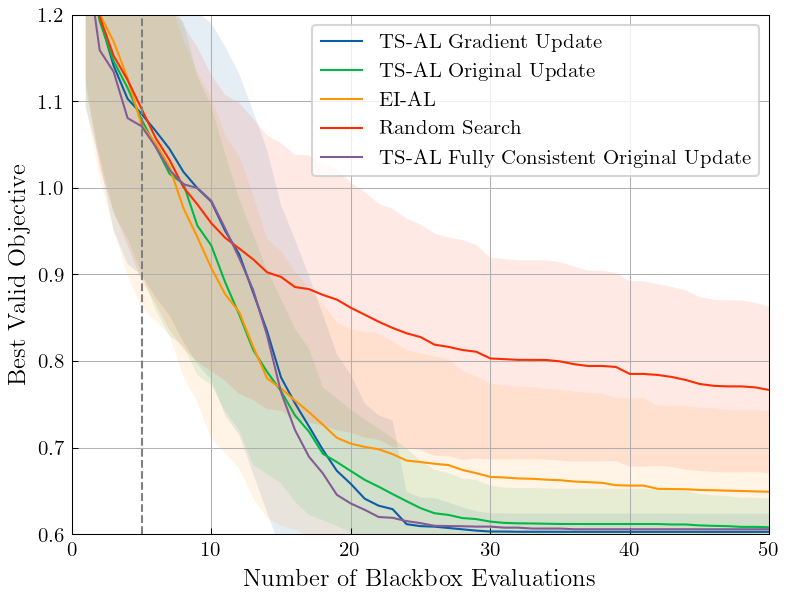

In [12]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 51)]
plt.plot(iters, ts_al_kkt_lsq_results_mean[:50], label="TS-AL Gradient Update")
plt.plot(iters, ts_al_original_lsq_results_mean[:50], label="TS-AL Original Update")
plt.plot(iters, original_albo_lsq_results_mean, label="EI-AL")
plt.plot(iters, random_lsq_results_mean[:50], label="Random Search")
plt.plot(iters, consistent_results_mean[:50], label="TS-AL Fully Consistent Original Update")
plt.axvline(x=5, color='grey', linestyle='--')
plt.fill_between(iters, ts_al_kkt_lsq_results_mean[:50]+ts_al_kkt_lsq_results_std[:50], ts_al_kkt_lsq_results_mean[:50]-ts_al_kkt_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_original_lsq_results_mean[:50]+ts_al_original_lsq_results_std[:50], ts_al_original_lsq_results_mean[:50]-ts_al_original_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_lsq_results_mean[:50]+original_albo_lsq_results_std[:50], original_albo_lsq_results_mean[:50]-original_albo_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_lsq_results_mean[:50]+random_lsq_results_std[:50], random_lsq_results_mean[:50]-random_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 50)
plt.ylim(0.6, 1.2)
plt.show()

### GSBP

In [26]:
ts_al_kkt_gsbp_results, ts_al_kkt_gsbp_results_mean, ts_al_kkt_gsbp_results_median, ts_al_kkt_gsbp_results_std = process_ts_gsbp_results("../results/05-04-23/gsbp/al_kkt_update/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_original_gsbp_results, ts_al_original_gsbp_results_mean, ts_al_original_gsbp_results_median, ts_al_original_gsbp_results_std = process_ts_gsbp_results("../results/05-04-23/gsbp/al_original_update/data/", 50, 2.1, equality_tolerance=0.01)
sobol_results, sobol_results_mean, sobol_results_median, sobol_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_ts_al_original_sobol_conservative_penalty/data/",
                                                                                                     50, 2.1, equality_tolerance=0.01)
true_sobol_results, true_sobol_results_mean, true_sobol_results_median, true_sobol_results_std = process_ts_gsbp_results("../results/13-04-23/gsbp_ts_al_original_sobol_conservative_penalty/data/", 50, 2.1, equality_tolerance=0.01)
aggressive_results, aggressive_results_mean, aggressive_results_median, aggressive_results_std = process_ts_gsbp_results("../results/12-04-23/gsbp_ts_al_original_sobol_aggressive_penalty/data/", 50, 2.1, equality_tolerance=0.01)
true_aggressive_results, true_aggressive_results_mean, true_aggressive_results_median, true_aggressive_results_std = process_ts_gsbp_results("../results/13-04-23/gsbp_ts_al_original_sobol_aggressive_penalty/data/", 50, 2.1, equality_tolerance=0.01)
original_albo_gsbp_results, original_albo_gsbp_results_mean, original_albo_gsbp_results_median, original_albo_gsbp_results_std = process_original_albo_gsbp_results("../results/original_albo/gsbp/slack_al_optim_correct_rho_update_urate_one/data/", 50, 2.1)
random_gsbp_results, random_gsbp_results_mean, random_gsbp_results_median, random_gsbp_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_random/", 50, 2.1, equality_tolerance=0.01)
final_aggressive_results, final_aggressive_results_mean, final_aggressive_results_median, final_aggressive_results_std = process_ts_gsbp_results("../results/15-04-23/gsbp_aggressive_fully_consistent/data/", 50, 2.1, equality_tolerance=0.01)
final_conservative_results, final_conservative_results_mean, final_conservative_results_median, final_conservative_results_std = process_ts_gsbp_results("../results/15-04-23/gsbp_conservative_fully_consistent/data/", 50, 2.1, equality_tolerance=0.01)

In [14]:
print(final_aggressive_results[:, -1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951]


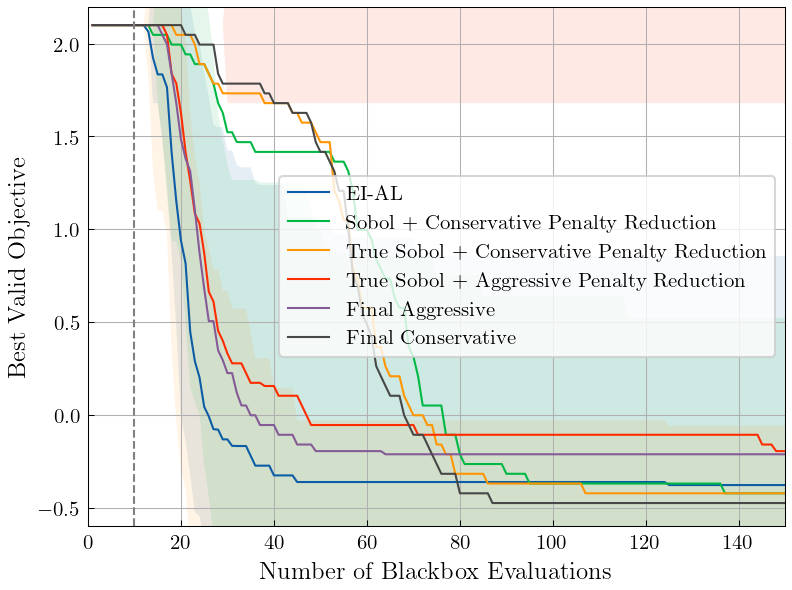

In [31]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 151)]
# plt.plot(iters, ts_al_kkt_gsbp_results_mean[:150], label="TS-AL Gradient Update")
# plt.plot(iters, ts_al_original_gsbp_results_mean[:150], label="TS-AL Original Update")
plt.plot(iters, original_albo_gsbp_results_mean, label="EI-AL")
# plt.plot(iters, random_gsbp_results_mean[:150], label="Random Search")
plt.plot(iters, sobol_results_mean[:150], label="Sobol + Conservative Penalty Reduction")
# plt.plot(iters, aggressive_results_mean[:150], label="Sobol + Aggressive Penalty Reduction")
plt.plot(iters, true_sobol_results_mean[:150], label="True Sobol + Conservative Penalty Reduction")
plt.plot(iters, true_aggressive_results_mean[:150], label="True Sobol + Aggressive Penalty Reduction")
plt.plot(iters, final_aggressive_results_mean[:150], label="Final Aggressive")
plt.plot(iters, final_conservative_results_mean[:150], label="Final Conservative")
plt.axvline(x=10, color='grey', linestyle='--')
plt.fill_between(iters, ts_al_kkt_gsbp_results_mean[:150]+ts_al_kkt_gsbp_results_std[:150], ts_al_kkt_gsbp_results_mean[:150]-ts_al_kkt_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_original_gsbp_results_mean[:150]+ts_al_original_gsbp_results_std[:150], ts_al_original_gsbp_results_mean[:150]-ts_al_original_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_gsbp_results_mean[:150]+original_albo_gsbp_results_std[:150], original_albo_gsbp_results_mean[:150]-original_albo_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_gsbp_results_mean[:150]+random_gsbp_results_std[:150], random_gsbp_results_mean[:150]-random_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 150)
plt.ylim(-0.6, 2.2)
plt.show()

In [25]:
with open(f"../results/14-04-23/lsq_fully_consistent/data/run_3_inequality_lambda_progression.pkl", "rb") as fp:
    lambd = pickle.load(fp)
lambd

{'INEQUALITY_CONSTRAINT_ONE': [<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.36603489])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([19.09810466])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([24.9644064])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([36.69700987])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  <tf.Tensor: shape=(1

In [24]:
with open(f"../results/09-02-23/batch_1_automatic_penalty/run_3_inequality_lambda_progression.pkl", "rb") as fp:
    lambd = pickle.load(fp)
lambd

{'INEQUALITY_CONSTRAINT_ONE': [<tf.Variable 'Variable:0' shape=(1, 1, 1) dtype=float64, numpy=array([[[0.]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.27520453]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-6.66133815e-16]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.23296362]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.6606006]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[21.84801114]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[52.59575154]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[37.03868473]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[193.69058899]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.96464698]]])>,
  <tf.Tensor: shape=(1, 1, 1), dtype=

In [13]:
with open(f"../results/11-04-23/gsbp_ts_al_original_sobol_conservative_penalty/data/run_1_trick_location_trajectory_observations.pkl", "rb") as fp:
    trick_obs = pickle.load(fp)

In [ ]:
run=2
with open(f"../results/12-04-23/gsbp_ts_al_original_sobol_aggressive_penalty/data/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)
data["OBJECTIVE"].observations[-10]

In [167]:
run = 26
with open(f"../results/05-04-23/gsbp/al_original_update/data/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)
data["OBJECTIVE"].query_points[:10]

<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
array([[0.65062058, 0.23672309],
       [0.13210708, 0.59205994],
       [0.59676325, 0.00981244],
       [0.06743639, 0.41250731],
       [0.96200489, 0.13931285],
       [0.33516351, 0.16665507],
       [0.73143159, 0.80984831],
       [0.23665159, 0.40800009],
       [0.67895293, 0.70223735],
       [0.64627307, 0.37090931]])>

In [48]:
print(true_aggressive_results[:,-1])

[-0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
  2.1        -0.5273951   2.1        -0.5273951  -0.5273951  -0.5273951
  0.32428761 -0.5273951  -0.5273951   2.1        -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
  2.1        -0.5273951  -0.5273951  -0.5273951   2.1        -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951   2.1       ]


In [40]:
print(aggressive_results[:,-1])

[-0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951  2.1        2.1
 -0.5273951 -0.5273951]


In [15]:
print(true_sobol_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951]


In [41]:
print(sobol_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951]


In [165]:
print(ts_al_original_gsbp_results[:,-1])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951  2.1       -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951  2.1       -0.5273951 -0.5273951  2.1       -0.5273951
 -0.5273951 -0.5273951]


In [160]:
print(original_albo_gsbp_results[:,-100])

[-0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951   0.31824271
 -0.5273951   0.29696942 -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951   0.28881867 -0.5273951   0.29571856  0.31928504
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951   0.2906346
 -0.5273951  -0.5273951   0.29479246  0.31416716 -0.5273951   0.30049195
 -0.5273951   0.29887258]


In [1]:
from absl import app, flags
import tensorflow as tf
import numpy as np
import trieste
from trieste.acquisition.optimizer import generate_al_continuous_optimizer
from trieste.acquisition.function.new_constrained_thompson_sampling import BatchThompsonSamplingAugmentedLagrangian
from trieste.acquisition.rule import ALEfficientGlobalOptimization
from trieste.models.gpflow import build_zero_mean_gpr, build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives
from functools import partial
import pickle

2023-04-12 16:22:44.766624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 16:22:52.134444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"


In [13]:
def create_model(search_space, num_rff_features, data):
    gpr = build_zero_mean_gpr(data, search_space, likelihood_variance=1e-7, kernel_priors=False)
    return GaussianProcessRegression(gpr, num_rff_features=num_rff_features)

In [14]:
search_space = Box([0.0, 0.0], [1.0, 1.0])

observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.goldstein_price,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        EQUALITY_CONSTRAINT_ONE=constraints.centered_branin,
        EQUALITY_CONSTRAINT_TWO=constraints.parr_constraint)

initial_inputs = search_space.sample_sobol(10, skip=42+10)
print(f"Initial Inputs: {initial_inputs}")
initial_data = observer(initial_inputs)
initial_models = trieste.utils.map_values(partial(create_model, search_space, 1000),
                                          initial_data)

Initial Inputs: [[0.953125 0.859375]
 [0.703125 0.109375]
 [0.203125 0.609375]
 [0.140625 0.421875]
 [0.640625 0.921875]
 [0.890625 0.171875]
 [0.390625 0.671875]
 [0.265625 0.046875]
 [0.765625 0.546875]
 [0.515625 0.296875]]


In [15]:
initial_models['EQUALITY_CONSTRAINT_ONE'].model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.28284 0.28284]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.0
GPR.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[0.95312, 0.85938..."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[-0.90831...


In [26]:
run = 6
with open(f"../results/05-04-23/gsbp/al_original_update/data/run_{run}_data.pkl", "rb") as fp:
    data = pickle.load(fp)
data["OBJECTIVE"].query_points

<tf.Tensor: shape=(150, 2), dtype=float64, numpy=
array([[0.9286243 , 0.77142849],
       [0.34055484, 0.86262469],
       [0.33446332, 0.36532227],
       [0.09988221, 0.05510078],
       [0.19258045, 0.08625854],
       [0.43099064, 0.42097884],
       [0.06000729, 0.60409479],
       [0.34099581, 0.56349509],
       [0.96959263, 0.27337429],
       [0.32161795, 0.04567945],
       [0.33554927, 0.35832188],
       [0.47987162, 0.35773457],
       [0.31436599, 0.39925758],
       [0.27336529, 0.42356026],
       [0.36645972, 0.43781978],
       [0.38248333, 0.46620647],
       [0.30451596, 0.45710047],
       [0.34985106, 0.45500518],
       [0.80822296, 1.        ],
       [1.        , 0.32401945],
       [0.92177362, 0.28653998],
       [0.26717084, 0.47292282],
       [0.20558167, 0.37163326],
       [0.96528689, 0.4936634 ],
       [0.93100886, 0.4512978 ],
       [0.95011553, 0.46817887],
       [0.94646756, 0.46927999],
       [0.94774845, 0.46899851],
       [0.94767733, 0.4685